# HW 4.Сравнение автоэнкодеров и ResNet репрезентаций

В этом задании, вам предлагается сравнить эмбеддинги картинок, принадлежащих различным классам из CIFAR-10. Для сравнения, предлагается рассмотреть эмбеддинги, полученные из обученного классификатора, и эмбеддинги из автоэнкодера.

Вам нужно реализовать следующие функции:
- Извлечение эмбеддингов из предобученного классификатора;
- Снижение размерности эмбеддингов с помощью PCA;
- Обучение автоэнкодера и извлечение его признаков;
- Написание функции визуализации

# 1. Загрузка CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import timm
from sklearn.decomposition import PCA



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to Tensor and scale to [0,1]
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# 2. Загрузка предобученной модели

В данной задаче от вас не требуется обучать новую модель. Мы воспользуемся предобученной модели ResNet18 на ImageNet. Под эмбеддингом будем понимать вектор, полученный до последнего слоя классификации.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# ========== не знаю почему но я не могу загрузить веса по ссылкам =======================================================================================
# ========== веса грузил вручную из https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet18_a2_0-b61bd467.pth ======
# ========== тут танец с бубном, сори! ===================================================================================================================

# Путь к весам
weights_path = r"C:\Users\User_1\.cache\torch\hub\checkpoints\resnet18_a2_0-b61bd467.pth"

# Создание модели с оригинальной архитектурой (включая fc-слой)
classificator = timm.create_model("resnet18", pretrained=False, num_classes=1000).to(device)

# Загрузка весов
state_dict = torch.load(weights_path, map_location=device)

# Удаление ненужных ключей для resnet18_a2_0-b61bd467.pth  не требуется
# state_dict = {k: v for k, v in state_dict.items() if not k.startswith('fc.')}

# Загрузка весов (strict=False позволяет пропустить несовпадающие ключи)
classificator.load_state_dict(state_dict, strict=False)

# Замена последнего слоя
classificator.fc = nn.Linear(512, 10).to(device)  # 512 - размер эмбеддинга, 10 - новых классов

# Заморозка весов
for param in classificator.parameters():
    param.requires_grad = False

print(classificator)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [5]:
# Визуализируем 100 картинок
max_steps = 10
# Сохраненные эмбеддинги
embeddings = []
# Сохраняем классы эмбеддингов
classes = []

# Хук для извлечения эмбеддингов перед последним слоем
def get_features_hook(module, input, output):
    embeddings.append(output.detach().cpu().numpy())

# Регистрация хука перед fc-слоем
hook = classificator.fc.register_forward_hook(get_features_hook)

for i, (images, labels) in enumerate(test_loader):
    if i >= max_steps:
        break
    
    images = images.to(device)
    
    # Передача данных через модель
    with torch.no_grad():
        outputs = classificator(images)
    
    # Сохранение меток классов
    classes.extend(labels.cpu().numpy())

# Удаление хука после использования
hook.remove()

# Преобразование списков в numpy массивы
embeddings = np.concatenate(embeddings, axis=0)
classes = np.array(classes)

In [6]:
if torch.is_tensor(embeddings):
    embeddings = embeddings.cpu().numpy()  # Перенос на CPU и конвертирование в numpy
if torch.is_tensor(classes):
    classes = classes.cpu().numpy()  # -//-

# Передаем эмбеддинги в PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

In [7]:
def get_plot(title, embedd, cls, xlabel, ylabel, colorbar_label):
    '''
    Функция визуализации
    '''   
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        embedd[:, 0], 
        embedd[:, 1], 
        c=cls, 
        cmap='tab10', 
        alpha=0.6
    )
    plt.colorbar(scatter, ticks=range(10), label=colorbar_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

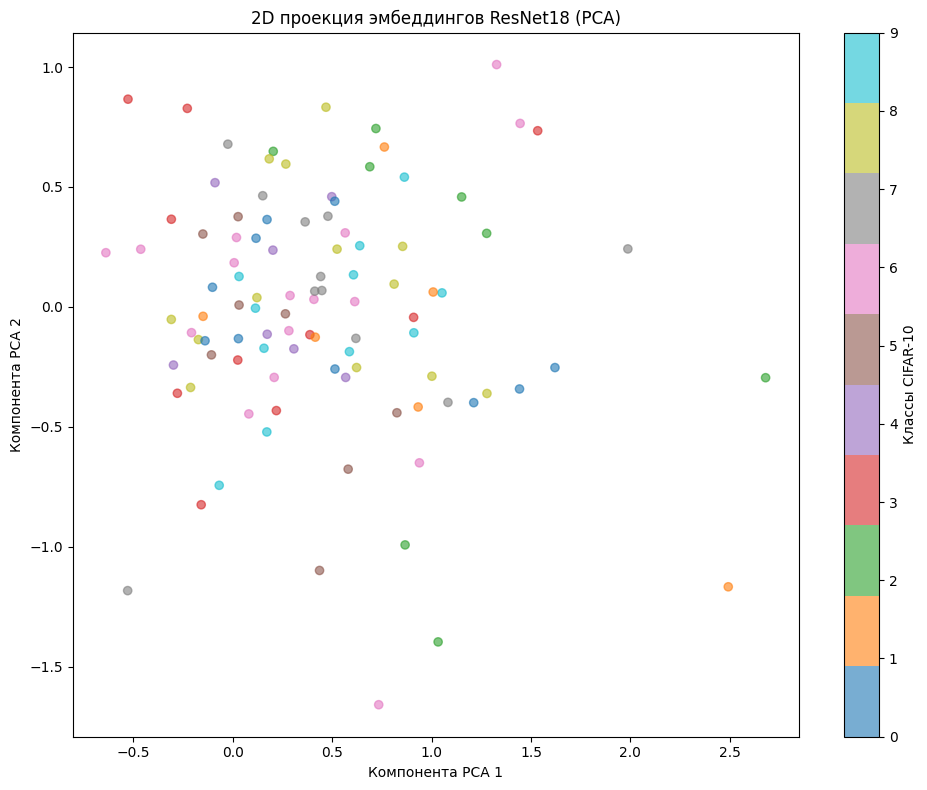

In [8]:
# Визуализация
get_plot('2D проекция эмбеддингов ResNet18 (PCA)', embeddings, classes, 'Компонента PCA 1', 'Компонента PCA 2', 'Классы CIFAR-10')

# 3. Обучение автоэнкодера

В данной реализации приведен не очень хороший, но рабочий автоэнкодер. Его уже придется обучить на тренировочном датасете

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),           
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(in_features=768,out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128,out_features=latent_dim),
            nn.LeakyReLU(0.1)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(in_features=latent_dim,out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128,out_features=768),
            nn.LeakyReLU(0.1)
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        encoded = torch.flatten(encoded, 1)
        encoded = self.linear1(encoded)

        decoded = self.linear2(encoded)
        decoded = decoded.reshape(-1,48,4,4)
        decoded = self.decoder(decoded)
        return decoded

    def encode(self, x):
      encoded = self.encoder(x)

      encoded = torch.flatten(encoded, 1)
      encoded = self.linear1(encoded)
      return encoded

In [10]:
latent_dim = 2
autoencoder = Autoencoder(latent_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)


In [11]:
# Перемещение модели на device
autoencoder = autoencoder.to(device)

In [12]:
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6561
Epoch [2/10], Loss: 0.6453
Epoch [3/10], Loss: 0.6169
Epoch [4/10], Loss: 0.6414
Epoch [5/10], Loss: 0.6196
Epoch [6/10], Loss: 0.6086
Epoch [7/10], Loss: 0.6488
Epoch [8/10], Loss: 0.6505
Epoch [9/10], Loss: 0.6530
Epoch [10/10], Loss: 0.6198


In [13]:
# Визуализируем 100 картинок
max_steps = 10
# Сохраненные эмбеддинги
embeddings = []
# Сохраняем классы эмбеддингов
classes = []

# Перевод модели в режим оценки
autoencoder.eval()

with torch.no_grad():  # Отключение вычисления градиентов
    for i, (images, labels) in enumerate(test_loader):
        if i >= max_steps:  # Ограничение количества батчей
            break
            
        # Получение эмбеддингов через метод encode
        batch_embeddings = autoencoder.encode(images.to(device))
        
        # Добавление в списки
        embeddings.append(batch_embeddings.cpu().numpy())
        classes.append(labels.numpy())

# Объединение батчей в один массив
embeddings = np.concatenate(embeddings, axis=0)
classes = np.concatenate(classes, axis=0)

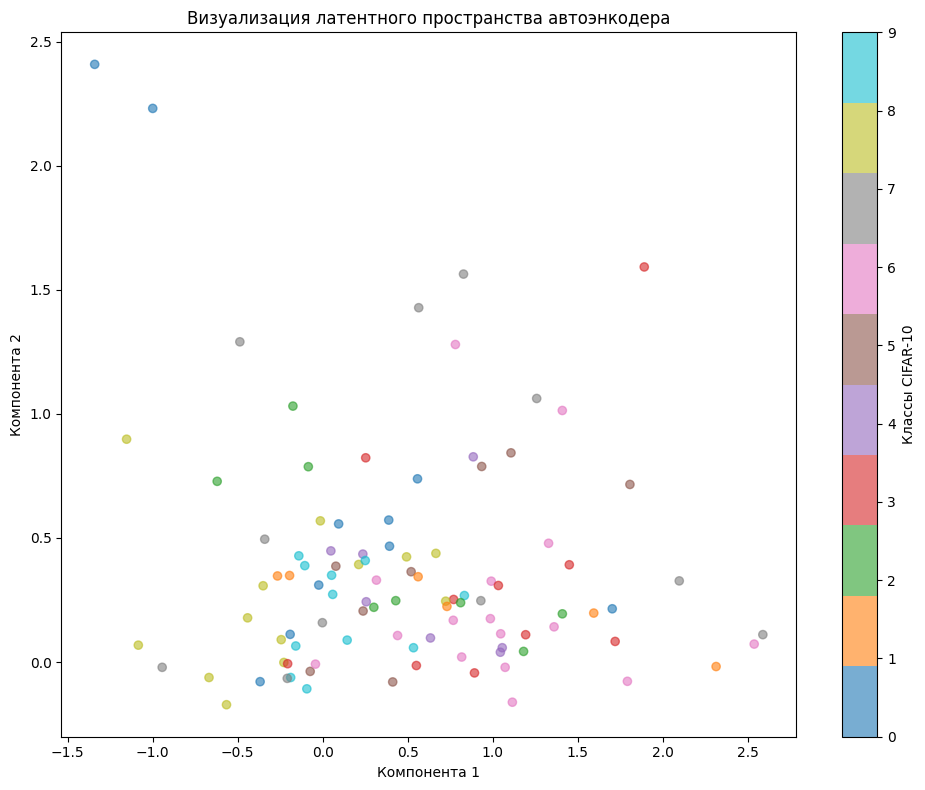

In [14]:
# Визуализация
get_plot('Визуализация латентного пространства автоэнкодера', embeddings, classes, 'Компонента 1', 'Компонента 2', 'Классы CIFAR-10')